In [91]:
import functools
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.layers import Dense, GlobalMaxPool1D, Embedding
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [92]:
#get data
filepath_dict = {'SearchCreativeWork' : 'intent-train-data/SearchCreativeWork.txt',
                 'GetWeather' : 'intent-train-data/GetWeather.txt',
                 'BookRestaurant' : 'intent-train-data/BookRestaurant.txt',
                 'PlayMusic' : 'intent-train-data/PlayMusic.txt',
                 'AddToPlaylist' : 'intent-train-data/AddToPlaylist.txt',
                 'RateBook' : 'intent-train-data/RateBook.txt',
                 'SearchScreeningEvent' : 'intent-train-data/SearchScreeningEvent.txt'}

df_list = []
label_num = 0
for src, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence'])
    df['source'] = src
    df['label'] = label_num
    df_list.append(df)
    label_num += 1
    
df = pd.concat(df_list)
df.iloc[1956]

sentence    Is it supposed to rain nearby my current locat...
source                                             GetWeather
label                                                       1
Name: 2, dtype: object

In [93]:
#preprocessing the data
sentences = []
label =[]

for src in df['source'].unique():
    df_src = df[df['source'] == src]
    sentences = np.append(sentences, df_src['sentence'].values)
    label = np.append(label, df_src['label'].values)

#split train and test
x_train, x_test, y_train, y_test = train_test_split(sentences, 
                                                    label,
                                                    test_size=0.25,
                                                    random_state=1000)
y_train = np_utils.to_categorical(y_train, 7)
y_test = np_utils.to_categorical(y_test, 7)

# Let try k-nearest Neighbors

In [94]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train)

X_train = vectorizer.transform(x_train)
X_test = vectorizer.transform(x_test)

model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train, y_train)

scoreTrain = model.score(X_train, y_train)
scoreVal = model.score(X_test, y_test)

print("Score Train: {}, Score Validation: {}".format(scoreTrain, scoreVal))

Score Train: 0.9495700898463917, Score Validation: 0.9353810489713127


# How about some keras model ?

In [95]:
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(7, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 10)                94530     
_________________________________________________________________
dense_18 (Dense)             (None, 7)                 77        
Total params: 94,607
Trainable params: 94,607
Non-trainable params: 0
_________________________________________________________________


In [96]:
history = model.fit(X_train, y_train, epochs=20, batch_size=10, 
                    validation_data=(X_test, y_test), verbose=1)

Train on 10351 samples, validate on 3451 samples
Epoch 1/20
10351/10351 [==============================] - 2s 173us/step - loss: 0.2536 - acc: 0.9123 - val_loss: 0.0696 - val_acc: 0.9856
Epoch 2/20
10351/10351 [==============================] - 3s 335us/step - loss: 0.0398 - acc: 0.9918 - val_loss: 0.0328 - val_acc: 0.9904
Epoch 3/20
10351/10351 [==============================] - 4s 376us/step - loss: 0.0191 - acc: 0.9954 - val_loss: 0.0247 - val_acc: 0.9923
Epoch 4/20
10351/10351 [==============================] - 4s 378us/step - loss: 0.0120 - acc: 0.9972 - val_loss: 0.0215 - val_acc: 0.9924
Epoch 5/20
10351/10351 [==============================] - 4s 381us/step - loss: 0.0083 - acc: 0.9980 - val_loss: 0.0201 - val_acc: 0.9931
Epoch 6/20
10351/10351 [==============================] - 4s 381us/step - loss: 0.0060 - acc: 0.9984 - val_loss: 0.0193 - val_acc: 0.9932
Epoch 7/20
10351/10351 [==============================] - 4s 384us/step - loss: 0.0044 - acc: 0.9990 - val_loss: 0.0191 - v

In [97]:
loss, accuracy = model.evaluate(X_train, y_train)
print("Training accuracy: {}, Training loss: {}".format(accuracy, loss))
loss, accuracy = model.evaluate(X_test, y_test)
print("Testing accuracy: {}, Training loss: {}".format(accuracy, loss))

10351/10351 [==============================] - 0s 42us/step
Training accuracy: 1.0, Training loss: 7.4946792037928e-05
3451/3451 [==============================] - 0s 47us/step
Testing accuracy: 0.9931696807256957, Training loss: 0.028221780653781926


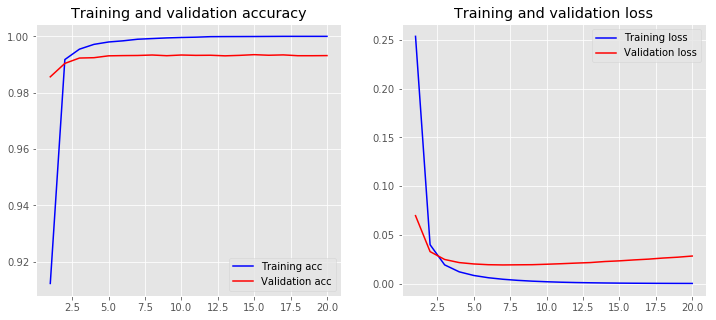

In [98]:
plt.style.use('ggplot')

#drawing function
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
plot_history(history)

# Tokenizer + OneHot word Embedding

In [99]:
#Filter with some special symbols
special_symbols = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'
token = Tokenizer(filters=special_symbols, num_words=5000)
token.fit_on_texts(x_train)

X_train = token.texts_to_sequences(x_train)
X_test = token.texts_to_sequences(x_test)

vocab_size = len(token.word_index) + 1

maxlen = len(max(sentences, key = len))
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [100]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=maxlen))
model.add(GlobalMaxPool1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 186, 50)           478950    
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 50)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_20 (Dense)             (None, 7)                 231       
Total params: 480,813
Trainable params: 480,813
Non-trainable params: 0
_________________________________________________________________


In [101]:
history = model.fit(X_train, y_train, verbose=1,
                    validation_data=(X_test, y_test), 
                    epochs=10, batch_size=32)

Train on 10351 samples, validate on 3451 samples
Epoch 1/10
10351/10351 [==============================] - 2s 201us/step - loss: 0.2184 - acc: 0.9188 - val_loss: 0.0433 - val_acc: 0.9887
Epoch 2/10
10351/10351 [==============================] - 2s 193us/step - loss: 0.0249 - acc: 0.9929 - val_loss: 0.0236 - val_acc: 0.9925
Epoch 3/10
10351/10351 [==============================] - 2s 202us/step - loss: 0.0116 - acc: 0.9968 - val_loss: 0.0206 - val_acc: 0.9929
Epoch 4/10
10351/10351 [==============================] - 2s 237us/step - loss: 0.0064 - acc: 0.9987 - val_loss: 0.0195 - val_acc: 0.9935
Epoch 5/10
10351/10351 [==============================] - 3s 278us/step - loss: 0.0039 - acc: 0.9992 - val_loss: 0.0183 - val_acc: 0.9941
Epoch 6/10
10351/10351 [==============================] - 3s 275us/step - loss: 0.0024 - acc: 0.9995 - val_loss: 0.0184 - val_acc: 0.9939
Epoch 7/10
10351/10351 [==============================] - 3s 289us/step - loss: 0.0016 - acc: 0.9997 - val_loss: 0.0185 - v

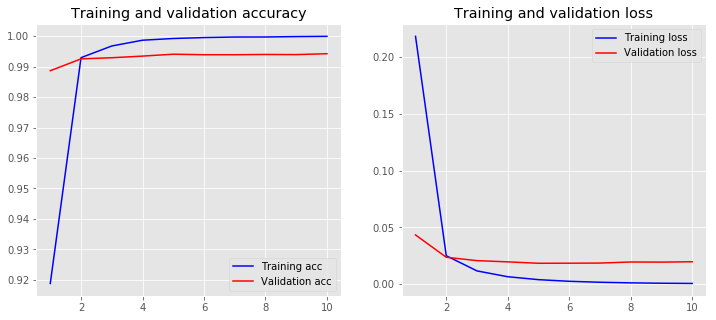

In [102]:
plot_history(history)

In [103]:
loss, accuracy = model.evaluate(X_train, y_train)
print("Training accuracy: {}, Training loss: {}".format(accuracy, loss))
loss, accuracy = model.evaluate(X_test, y_test)
print("Testing accuracy: {}, Training loss: {}".format(accuracy, loss))

10351/10351 [==============================] - 0s 40us/step
Training accuracy: 0.9999723973429476, Training loss: 0.0003675613533518186
3451/3451 [==============================] - 0s 41us/step
Testing accuracy: 0.9942459696723012, Training loss: 0.019660666683336308


In [104]:
#using top 3 accuracy
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=maxlen))
model.add(GlobalMaxPool1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', top3_acc])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 186, 50)           478950    
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 50)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                1632      
_________________________________________________________________
dense_22 (Dense)             (None, 7)                 231       
Total params: 480,813
Trainable params: 480,813
Non-trainable params: 0
_________________________________________________________________


In [105]:
history = model.fit(X_train, y_train, verbose=1,
                    validation_data=(X_test, y_test), 
                    epochs=10, batch_size=32)

Train on 10351 samples, validate on 3451 samples
Epoch 1/10
  896/10351 [=>............................] - ETA: 1s - loss: 0.4080 - acc: 0.8571 - top3_acc: 0.5067

/Users/luudat/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


10351/10351 [==============================] - 2s 186us/step - loss: 0.2248 - acc: 0.9166 - top3_acc: 0.9345 - val_loss: 0.0473 - val_acc: 0.9872 - val_top3_acc: 0.9954
Epoch 2/10
10351/10351 [==============================] - 2s 195us/step - loss: 0.0280 - acc: 0.9921 - top3_acc: 0.9977 - val_loss: 0.0249 - val_acc: 0.9919 - val_top3_acc: 0.9974
Epoch 3/10
10351/10351 [==============================] - 2s 207us/step - loss: 0.0129 - acc: 0.9962 - top3_acc: 0.9992 - val_loss: 0.0207 - val_acc: 0.9935 - val_top3_acc: 0.9986
Epoch 4/10
10351/10351 [==============================] - 2s 230us/step - loss: 0.0072 - acc: 0.9980 - top3_acc: 0.9999 - val_loss: 0.0189 - val_acc: 0.9940 - val_top3_acc: 0.9983
Epoch 5/10
10351/10351 [==============================] - 3s 265us/step - loss: 0.0043 - acc: 0.9992 - top3_acc: 0.9999 - val_loss: 0.0188 - val_acc: 0.9940 - val_top3_acc: 0.9977
Epoch 6/10
10351/10351 [==============================] - 3s 291us/step - loss: 0.0027 - acc: 0.9994 - top3_acc

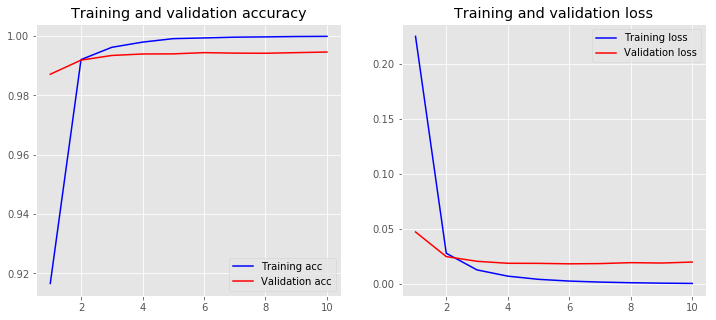

In [106]:
plot_history(history)